# Setup

In [11]:
from pycqed.analysis import measurement_analysis as ma
import itertools
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import *
import numpy as np
from pycqed.measurement import qaoa
from pycqed.analysis import analysis_toolbox as a_tools
a_tools.datadir = "Q:\\USERS\\nathan\\data\\thesis_data"
figsave_base = "C:\\Users\\nathan\\projects\\master_thesis\\chapters\\qaoa\\figs\\"

## plotting style

In [2]:
fig_size_dim    = 8
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 16
    marker_size     = 6
    line_width      = 2.5
    axes_line_width = 1
    tick_length     = 5
    tick_width      = 1
    tick_color      = 'k'
    ticks_direction = 'in'
    axes_labelcolor = 'k'
    dpi             =  800

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "DIN Pro",#"cmss10", #"DINPro", # to manage to use dinpro, put ttf files in site-packages/matplotlib/mpl-data/fonts
              'mathtext.default': 'it',
              'mathtext.fontset': "cm",
              'mathtext.it': 'cm',
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.labelcolor': axes_labelcolor,
              'axes.titlesize': font_size,
              'axes.linewidth': axes_line_width,
              'lines.markersize': marker_size,
              'lines.linewidth': line_width,
              'xtick.direction': ticks_direction,
              'ytick.direction': ticks_direction,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'xtick.color': tick_color,
              'ytick.color': tick_color,
              'xtick.major.size': tick_length,
              'ytick.major.size': tick_length,
              'xtick.major.width': tick_width,
              'ytick.major.width': tick_width,
              'xtick.top': True,
              'xtick.bottom': True,
              'ytick.left': True,
              'ytick.right': True,
              'axes.formatter.useoffset': False,
              'pdf.fonttype' : 42, 
              'ps.fonttype' : 42,

              # LEGEND
            'legend.loc'           : 'best',
            'legend.frameon'       : False,     ## if True, draw the legend on a background patch
    #         'legend.framealpha'    : 0.8,      ## legend patch transparency
    #         'legend.facecolor'     : 'inherit',  ## inherit from axes.facecolor; or color spec
    #         'legend.edgecolor'     : 0.8,      ## background patch boundary color
    #         'legend.fancybox'      : True,     ## if True, use a rounded box for the
                                             ## legend background, else a rectangle
                }

    plt.rcParams.update(params)
plot_style()


In [3]:
# unit to have radians in plots
"""
===========
Basic Units, used to display axis in units of pi
===========

"""

import math

import numpy as np

import matplotlib.units as units
import matplotlib.ticker as ticker


class ProxyDelegate(object):
    def __init__(self, fn_name, proxy_type):
        self.proxy_type = proxy_type
        self.fn_name = fn_name

    def __get__(self, obj, objtype=None):
        return self.proxy_type(self.fn_name, obj)


class TaggedValueMeta(type):
    def __init__(self, name, bases, dict):
        for fn_name in self._proxies:
            try:
                dummy = getattr(self, fn_name)
            except AttributeError:
                setattr(self, fn_name,
                        ProxyDelegate(fn_name, self._proxies[fn_name]))


class PassThroughProxy(object):
    def __init__(self, fn_name, obj):
        self.fn_name = fn_name
        self.target = obj.proxy_target

    def __call__(self, *args):
        fn = getattr(self.target, self.fn_name)
        ret = fn(*args)
        return ret


class ConvertArgsProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        converted_args = []
        for a in args:
            try:
                converted_args.append(a.convert_to(self.unit))
            except AttributeError:
                converted_args.append(TaggedValue(a, self.unit))
        converted_args = tuple([c.get_value() for c in converted_args])
        return PassThroughProxy.__call__(self, *converted_args)


class ConvertReturnProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        ret = PassThroughProxy.__call__(self, *args)
        return (NotImplemented if ret is NotImplemented
                else TaggedValue(ret, self.unit))


class ConvertAllProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        converted_args = []
        arg_units = [self.unit]
        for a in args:
            if hasattr(a, 'get_unit') and not hasattr(a, 'convert_to'):
                # if this arg has a unit type but no conversion ability,
                # this operation is prohibited
                return NotImplemented

            if hasattr(a, 'convert_to'):
                try:
                    a = a.convert_to(self.unit)
                except Exception:
                    pass
                arg_units.append(a.get_unit())
                converted_args.append(a.get_value())
            else:
                converted_args.append(a)
                if hasattr(a, 'get_unit'):
                    arg_units.append(a.get_unit())
                else:
                    arg_units.append(None)
        converted_args = tuple(converted_args)
        ret = PassThroughProxy.__call__(self, *converted_args)
        if ret is NotImplemented:
            return NotImplemented
        ret_unit = unit_resolver(self.fn_name, arg_units)
        if ret_unit is NotImplemented:
            return NotImplemented
        return TaggedValue(ret, ret_unit)


class TaggedValue(metaclass=TaggedValueMeta):

    _proxies = {'__add__': ConvertAllProxy,
                '__sub__': ConvertAllProxy,
                '__mul__': ConvertAllProxy,
                '__rmul__': ConvertAllProxy,
                '__cmp__': ConvertAllProxy,
                '__lt__': ConvertAllProxy,
                '__gt__': ConvertAllProxy,
                '__len__': PassThroughProxy}

    def __new__(cls, value, unit):
        # generate a new subclass for value
        value_class = type(value)
        try:
            subcls = type(f'TaggedValue_of_{value_class.__name__}',
                          (cls, value_class), {})
            if subcls not in units.registry:
                units.registry[subcls] = basicConverter
            return object.__new__(subcls)
        except TypeError:
            if cls not in units.registry:
                units.registry[cls] = basicConverter
            return object.__new__(cls)

    def __init__(self, value, unit):
        self.value = value
        self.unit = unit
        self.proxy_target = self.value

    def __getattribute__(self, name):
        if name.startswith('__'):
            return object.__getattribute__(self, name)
        variable = object.__getattribute__(self, 'value')
        if hasattr(variable, name) and name not in self.__class__.__dict__:
            return getattr(variable, name)
        return object.__getattribute__(self, name)

    def __array__(self, dtype=object):
        return np.asarray(self.value).astype(dtype)

    def __array_wrap__(self, array, context):
        return TaggedValue(array, self.unit)

    def __repr__(self):
        return 'TaggedValue({!r}, {!r})'.format(self.value, self.unit)

    def __str__(self):
        return str(self.value) + ' in ' + str(self.unit)

    def __len__(self):
        return len(self.value)

    def __iter__(self):
        # Return a generator expression rather than use `yield`, so that
        # TypeError is raised by iter(self) if appropriate when checking for
        # iterability.
        return (TaggedValue(inner, self.unit) for inner in self.value)

    def get_compressed_copy(self, mask):
        new_value = np.ma.masked_array(self.value, mask=mask).compressed()
        return TaggedValue(new_value, self.unit)

    def convert_to(self, unit):
        if unit == self.unit or not unit:
            return self
        try:
            new_value = self.unit.convert_value_to(self.value, unit)
        except AttributeError:
            new_value = self
        return TaggedValue(new_value, unit)

    def get_value(self):
        return self.value

    def get_unit(self):
        return self.unit


class BasicUnit(object):
    def __init__(self, name, fullname=None):
        self.name = name
        if fullname is None:
            fullname = name
        self.fullname = fullname
        self.conversions = dict()

    def __repr__(self):
        return f'BasicUnit({self.name})'

    def __str__(self):
        return self.fullname

    def __call__(self, value):
        return TaggedValue(value, self)

    def __mul__(self, rhs):
        value = rhs
        unit = self
        if hasattr(rhs, 'get_unit'):
            value = rhs.get_value()
            unit = rhs.get_unit()
            unit = unit_resolver('__mul__', (self, unit))
        if unit is NotImplemented:
            return NotImplemented
        return TaggedValue(value, unit)

    def __rmul__(self, lhs):
        return self*lhs

    def __array_wrap__(self, array, context):
        return TaggedValue(array, self)

    def __array__(self, t=None, context=None):
        ret = np.array([1])
        if t is not None:
            return ret.astype(t)
        else:
            return ret

    def add_conversion_factor(self, unit, factor):
        def convert(x):
            return x*factor
        self.conversions[unit] = convert

    def add_conversion_fn(self, unit, fn):
        self.conversions[unit] = fn

    def get_conversion_fn(self, unit):
        return self.conversions[unit]

    def convert_value_to(self, value, unit):
        conversion_fn = self.conversions[unit]
        ret = conversion_fn(value)
        return ret

    def get_unit(self):
        return self


class UnitResolver(object):
    def addition_rule(self, units):
        for unit_1, unit_2 in zip(units[:-1], units[1:]):
            if unit_1 != unit_2:
                return NotImplemented
        return units[0]

    def multiplication_rule(self, units):
        non_null = [u for u in units if u]
        if len(non_null) > 1:
            return NotImplemented
        return non_null[0]

    op_dict = {
        '__mul__': multiplication_rule,
        '__rmul__': multiplication_rule,
        '__add__': addition_rule,
        '__radd__': addition_rule,
        '__sub__': addition_rule,
        '__rsub__': addition_rule}

    def __call__(self, operation, units):
        if operation not in self.op_dict:
            return NotImplemented

        return self.op_dict[operation](self, units)


unit_resolver = UnitResolver()

cm = BasicUnit('cm', 'centimeters')
inch = BasicUnit('inch', 'inches')
inch.add_conversion_factor(cm, 2.54)
cm.add_conversion_factor(inch, 1/2.54)

radians = BasicUnit('rad', 'radians')
degrees = BasicUnit('deg', 'degrees')
radians.add_conversion_factor(degrees, 180.0/np.pi)
degrees.add_conversion_factor(radians, np.pi/180.0)

secs = BasicUnit('s', 'seconds')
hertz = BasicUnit('Hz', 'Hertz')
minutes = BasicUnit('min', 'minutes')

secs.add_conversion_fn(hertz, lambda x: 1./x)
secs.add_conversion_factor(minutes, 1/60.0)


# radians formatting
def rad_fn(x, pos=None):
    if x >= 0:
        n = int((x / np.pi) * 2.0 + 0.25)
    else:
        n = int((x / np.pi) * 2.0 - 0.25)

    if n == 0:
        return '0'
    elif n == 1:
        return r'$\pi/2$'
    elif n == 2:
        return r'$\pi$'
    elif n == -1:
        return r'$-\pi/2$'
    elif n == -2:
        return r'$-\pi$'
    elif n % 2 == 0:
        return fr'${n//2}\pi$'
    else:
        return fr'${n}\pi/2$'


class BasicUnitConverter(units.ConversionInterface):
    @staticmethod
    def axisinfo(unit, axis):
        'return AxisInfo instance for x and unit'

        if unit == radians:
            return units.AxisInfo(
                majloc=ticker.MultipleLocator(base=np.pi/2),
                majfmt=ticker.FuncFormatter(rad_fn),
                label=unit.fullname,
            )
        elif unit == degrees:
            return units.AxisInfo(
                majloc=ticker.AutoLocator(),
                majfmt=ticker.FormatStrFormatter(r'$%i^\circ$'),
                label=unit.fullname,
            )
        elif unit is not None:
            if hasattr(unit, 'fullname'):
                return units.AxisInfo(label=unit.fullname)
            elif hasattr(unit, 'unit'):
                return units.AxisInfo(label=unit.unit.fullname)
        return None

    @staticmethod
    def convert(val, unit, axis):
        if units.ConversionInterface.is_numlike(val):
            return val
        if np.iterable(val):
            if isinstance(val, np.ma.MaskedArray):
                val = val.astype(float).filled(np.nan)
            out = np.empty(len(val))
            for i, thisval in enumerate(val):
                if np.ma.is_masked(thisval):
                    out[i] = np.nan
                else:
                    try:
                        out[i] = thisval.convert_to(unit).get_value()
                    except AttributeError:
                        out[i] = thisval
            return out
        if np.ma.is_masked(val):
            return np.nan
        else:
            return val.convert_to(unit).get_value()

    @staticmethod
    def default_units(x, axis):
        'return the default unit for x or None'
        if np.iterable(x):
            for thisx in x:
                return thisx.unit
        return x.unit


def cos(x):
    if np.iterable(x):
        return [math.cos(val.convert_to(radians).get_value()) for val in x]
    else:
        return math.cos(x.convert_to(radians).get_value())


basicConverter = BasicUnitConverter()
units.registry[BasicUnit] = basicConverter
units.registry[TaggedValue] = basicConverter


## helper functions

In [4]:
def get_parameters(timestamp, all=True, gammas=False, betas=False, iteration=False, Cs=False,
                        energy=False, correlations=False, states_filtered=False):
    """
    Get relevant parameters from the measurement file. 'all' overrides all other parameters except 
        states filtered which has to be activated manually because it loads a lot of data.
    
    """
    params = {"timestamp": timestamp}
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    if all:
        gammas, betas, iteration, energy, correlations = [True]*5
    if gammas:
        params["gammas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])
    if betas:
        params["betas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])
    if iteration:
        params["iteration"] = a.data_file["Experimental Data"]["Experimental Metadata"].attrs['iteration']
    if energy:
        params["energy"] = a.data_file['Analysis']['Processed data']['analysis_params_dict'].attrs['energy']
    if correlations:
        params["correlations"] = {n:v for n, v in zip(
            a.data_file['Analysis']['Processed data']['correlations'].attrs['names'],
            a.data_file['Analysis']['Processed data']['correlations']['values'])}
    if states_filtered:
        params["states_filtered"] = a.data_file['Analysis']['Processed data']["qb_states_filtered"]
    if Cs:
        raise NotImplementedError()
    return params

def get_parameters_run(timestamps, **kwargs):
    
    b, g, e, c, it, s = [],[],[],[], [], []
    for t in timestamps:
        params = get_parameters(t, **kwargs)
        b.append(params.get("betas", np.nan))
        g.append(params.get("gammas", np.nan))
        it.append(params.get('iteration', np.nan))
        e.append(params.get('energy', np.nan))
        c.append(params.get('correlations', np.nan))
        s.append(params.get("qb_states_filtered", np.nan))

    params_run = {}
    params_run['betas'] = np.asarray(b)
    params_run['gammas'] = np.asarray(g)
    params_run['iterations'] = np.asarray(it)
    params_run["energy"] = np.asarray(e)
    params_run["correlations"] = np.asarray(c)
    params_run["iteration_mask"] = np.asarray([e == np.amin(e[it == i]) 
                                   for i in range(max(it)+1)])
    params_run["timestamps"] = timestamps
    return params_run

def get_parameters_runs(tstart, tend, **kwargs):
    #check for label name in case interleaved tomography
    tps = a_tools.get_timestamps_in_range(tstart, tend, label="QAOA") 
    fevals = np.array([eval(a_tools.get_folder(t).split("_")[-1]) for t in tps])
    n_all_files = -np.diff(np.pad(fevals, (0,1), 'constant'))[np.diff(np.pad(fevals, (0,1), 'constant')) != 1] + 1
    all_run_params = []
    for i, nfiles in enumerate(n_all_files):
        print(tps[np.sum(n_all_files[:i])])
#         print(len(tps))
        print(tps[np.sum(n_all_files[:i]) + nfiles-1])
#         print(n_all_files)
        tmps = a_tools.get_timestamps_in_range(tps[np.sum(n_all_files[:i])], 
                                               tps[np.sum(n_all_files[:i]) + nfiles-1])
        all_run_params.append(get_parameters_run(tmps, **kwargs))
    return all_run_params

def qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs):
    q = QubitCircuit(n_qbs, reverse_states=False)
    qubits = np.arange(n_qbs)

    assert len(Cs) == len(two_qb_pairs), f"Cs and two_qb_pairs do not match: {len(Cs) } vs {len(two_qb_pairs)}"
    
    # init
    for qb in qubits:
        q.add_gate("RY", targets=qb, arg_value=np.pi/2, arg_label=r'\frac{\pi}{2}')

    for g, b in zip(gammas, betas):
        for C, pair in zip(Cs, two_qb_pairs):
            q.add_gate("RZ", targets=pair[0], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("RZ", targets=pair[1], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("CPHASE", controls=pair[0], targets=pair[1], arg_value=(4*g*C) % (2*np.pi), arg_label=r'4\gamma C')
        for k,h in enumerate(hs):
            q.add_gate("RZ", targets=[k], arg_value=2*g*h, arg_label=r'-2\gamma C')

        # D
        for qb in qubits:
            q.add_gate("RX", targets=qb, arg_value=b, arg_label=r'\beta')

    U_list = q.propagators()
    return gate_sequence_product(U_list)

def cs_to_phys(labels):
    """
    changes list of labels '[0 1 0]' --> '$|010\rangle$'
    """
    labels = [str(l) for l in labels]
    return ["$|{}\\rangle$".format(l.translate({ord(i): None for i in '[() ],'})) 
            for l in labels]

def bar_plot(timestamp, gammas=None, betas=None, Cs=None, hs=None, 
             two_qb_pairs='linear_array', correct_states=None, plot=True, ax=None, save=False):
    """
    Creates histogram bar plot of measured states.
    Correct state formart: [b1 b2 ... bn]
    """
    results = {}
    
    # get qb states and parameters
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    states = np.asarray(a.data_file['Analysis']["Processed data"]["qubit_states"])
    results['states'] = states
    n_qbs = states.shape[1]
    qubits = np.arange(n_qbs)
    try:
        if gammas is None:
            gammas = a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']
        if betas is None:
            betas = a.data_file["Experimental Data"]["Experimental Metadata"]['betas']
    except TypeError:
        gammas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])]
        betas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])]
    
    results["depth"] = len(gammas)
    # counts for each label
    states_labels, counts = np.unique(states, axis=0, return_counts=True)
    states_labels = np.array(cs_to_phys([str(s) for s in states_labels]))
    filter = [True if not "2" in s else False for s in states_labels]
    results["state_probs"] = {l: c for l, c in zip(states_labels[filter], counts[filter]/np.sum(counts[filter]))}
    results['leakage_prob'] = np.sum(counts[~np.array(filter, dtype=bool)])/ np.sum(counts)
    if correct_states is not None:
        correct_states = cs_to_phys(correct_states)
        counts_in_subspace = np.sum(counts[filter])
        success_prob = np.sum([counts[states_labels == c] for c in correct_states]) / counts_in_subspace
        results["success_prob"] = success_prob
        
    #qutip computation of expected state
    if Cs is None:
        _, Cs = qaoa.QAOAHelper.get_corr_and_coupl_info(
            eval(a.data_file["Experimental Data"]["Experimental Metadata"].attrs['two_qb_gates_info']))
    if hs is None:
        hs = [0 for _ in range(n_qbs)]
    if two_qb_pairs == "linear_array":
        two_qb_pairs = [(i,j) for i,j in zip(qubits, qubits[1:]) ] 
    else:
        raise NotImplementedError()
    
    # qutip simulation
    U = qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs)
    H = U * ket("0"*len(qubits))
    results['expected_state'] = np.real((H*H.dag()).full()[np.eye(len(H.full()), dtype=bool)])
    results["expected_state_labels"] = np.array(cs_to_phys(list(itertools.product((0,1), repeat=n_qbs))))
    if correct_states is not None:
        success_prob_theory = np.sum([results['expected_state'][results["expected_state_labels"] == c] for c in correct_states])
        results['success_prob_theory'] = success_prob_theory
        
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.get_figure()
        order = list(reversed(np.argsort(counts[filter])))
        expected_state_labels_in_mmnt = [True if sl in states_labels[filter][order] else False for sl in results["expected_state_labels"]]
        ax.bar(states_labels[filter], counts[filter]/np.sum(counts[filter]),
              color='grey')
        ax.bar(results["expected_state_labels"][expected_state_labels_in_mmnt] , results['expected_state'][expected_state_labels_in_mmnt], 
               fill=False, linewidth=1, edgecolor='k', 
               label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
        if correct_states is not None:
            correct_states_counts = np.asarray([counts[states_labels == c]/np.sum(counts[filter]) for c in correct_states])
            
            ax.bar(correct_states, correct_states_counts.flatten() , 
                   color='green', label="$P_s$: {:.3f}".format(success_prob))
#             ax.legend()
        print(states_labels[filter])
        ax.xaxis.set_ticks(np.arange(len(states_labels[filter])))
        ax.xaxis.set_ticklabels(states_labels[filter],  rotation='vertical')
#         ax.set_ylabel("Fraction of measurements (arb. u.)")

        results['fig'] = fig
        if save:
            fig.tight_layout()
            fig.savefig(a.folder + "\\bit_strings_frequency.png")
            
    return results    


# Energy Landscapes

In [5]:
# landscape functions
from IPython.display import clear_output 
from copy import deepcopy
def plot_colormesh(xx, yy, zz, ax=None, labels=True, colorbar=True, **plot_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    plot_kwargs = deepcopy(plot_kwargs)
    vmin = plot_kwargs.pop("vmin", -1)
    vmax = plot_kwargs.pop("vmax", 1)
    cmap = plot_kwargs.pop("cmap", "seismic")
    im = ax.pcolormesh(np.pad(xx,(1,0), "linear_ramp"), np.pad(yy,(1,0), "linear_ramp"), zz, 
                       cmap=cmap, vmin=vmin, vmax=vmax, 
                       **plot_kwargs)
    if labels:
        ax.set_xlabel("gamma (rad.)")
        ax.set_ylabel("beta (rad.)")
    if colorbar:
        cb = fig.colorbar(im, label=r"$\sigma_z \sigma_z$ (arb. u.)")
    return im

def load_landscape_from_npy(timestamp):
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    a.data_file.close()
    gg = np.load(a.folder + "\\gammas.npy")
    bb = np.load(a.folder + "\\betas.npy")
    energy = np.load(a.folder + "\\energy.npy")
    # TODO: add leakage
    return gg, bb, energy, None, a

def load_landscape_from_analyzed_files(tstart, tend, save=False, plot=True):
    tps = a_tools.get_timestamps_in_range(tstart, tend)
    energy = []
    leakages = {}
    gammas = []
    betas = []
    an = []
    for j, t in enumerate(tps):
        print(j)
        a = ma.MeasurementAnalysis(timestamp=t, auto=False)
        gammas.append(np.array(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']))
        betas.append(np.array(a.data_file["Experimental Data"]["Experimental Metadata"]['betas']))
        e = list(a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["energy"])
        for qb, leak in a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["leakage"].items():
            if qb not in leakages:
                leakages[qb] = []
            leakages[qb].append(list(a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["leakage"][qb]))
        energy.append(e)
        an.append(a)
    clear_output()
    
    gg, bb, energy =  np.asarray(gammas),  np.asarray(betas), np.asarray(energy)
    print(gg.shape)
    print(bb.shape)
    print(energy.shape)
    if save:
        f = a.folder
        np.save(f + "\\gammas.npy", gg)
        np.save(f + "\\betas.npy", bb)
        np.save(f + "\\energy.npy", energy)
        for qb in leakages:
            np.save(f + f"\\leakage_{qb}.npy", leakages[qb])
    if plot:
        # plot landscape
        fig, ax = plt.subplots()
        cmap = "seismic"
        im = ax.pcolormesh(np.pad(gg,(1,0), "linear_ramp"), np.pad(bb,(1,0), "linear_ramp"), 
                           energy, cmap=cmap, vmin=-1.05, vmax=1.05)
        ax.set_xlabel("gamma (rad.)")
        ax.set_ylabel("beta (rad.)")
        cb = fig.colorbar(im, label=r"Energy (arb. u.)")
        if save:
            fig.savefig(f + "\\energy_landscape.png")
        # plot leakage
        for qb in leakages:
            fig, ax = plt.subplots()
            im = ax.pcolormesh(np.pad(gg,(1,0), "linear_ramp"), np.pad(bb,(1,0), "linear_ramp"), leakages[qb])
            ax.set_xlabel("gamma (rad.)")
            ax.set_ylabel("beta (rad.)")
            cb = fig.colorbar(im, label=f"leakage {qb}")
            if save:
                fig.savefig(f + f"\\leakage_{qb}.png")
            
    return np.asarray(gammas), np.asarray(betas), energy, leakages, an

In [12]:
# load landscape Direct
# tstart_tend = ["20191129_111634", "20191129_135651"] # BF1
# gg_dir, bb_dir, energy_dir, leakages_dir, an_dir = load_landscape_from_analyzed_files(*tstart_tend, save=False, plot=False)
t = "20191129_135651"
# t = "20200229_164442" # XLD Q1Q4Q2
# t = "20200222_232007" # XLD Q3Q1Q4
gg_dir, bb_dir, energy_dir, _, _ = load_landscape_from_npy(t)
print(gg_dir.shape)

(45, 45)


In [34]:
# load landscape Decomposed
# tstart_tend = ["20191205_223041","20191206_010735"] # BF1
# gg_dec, bb_dec, energy_dec, leakages_dec, an_dec = load_landscape_from_analyzed_files(tstart_tend[0], tstart_tend[1], save=False, plot=False)
# t = "20200227_213611" #XLD Q1Q4
t = "20200223_205152" # XLD Q3Q1Q4
gg_dec, bb_dec, energy_dec,_,_ = load_landscape_from_npy(t)
print(gg_dec.shape)

(45, 45)


In [7]:
# noise free simulation landscape
from qutip import *

# params 
n_qbs = 3
qubits = np.arange(n_qbs)
n_points = 45
gammas = np.linspace(0,np.pi, n_points)
betas = np.linspace(0,np.pi/2, n_points)
depth=1
hs = [0, 0., 0.] # single qb terms
# two_qb_pairs = list(itertools.combinations(qubits, 2)) # full connectivity
two_qb_pairs = [(i,j) for i,j in zip(qubits, qubits[1:]) ] # linear array
Cs = [0.5, 1] 

# create two d space
gg, bb = np.meshgrid(gammas, betas, indexing="ij")

# simulate
energy = np.zeros_like(gg)
corr = {p:np.zeros_like(gg) for p in two_qb_pairs}
single_qb_term = {qb:np.zeros_like(gg) for qb in range(n_qbs)}
assert len(Cs) == len(two_qb_pairs)
for i in range(len(gammas)):
    for j in range(len(betas)):
        g = gg[i,j]
        b = bb[i,j]
        
        q = QubitCircuit(n_qbs, reverse_states=False)

        # init
        for qb in qubits:
            q.add_gate("RY", targets=int(qb), arg_value=np.pi/2, arg_label=r'\frac{\pi}{2}')
        
        for d in range(depth):
            # U
            for C, pair in zip(Cs, two_qb_pairs):
                q.add_gate("RZ", targets=int(pair[0]), arg_value=2*g*C, arg_label=r'-2\gamma C')
                q.add_gate("RZ", targets=int(pair[1]), arg_value=2*g*C, arg_label=r'-2\gamma C')
                q.add_gate("CPHASE", controls=int(pair[0]), targets=int(pair[1]), arg_value=(-4*g*C) % (2*np.pi), arg_label=r'4\gamma C')
            for k,h in enumerate(hs):
                q.add_gate("RZ", targets=[k], arg_value=2*g*h, arg_label=r'-2\gamma C')

            # D
            for qb in qubits:
                q.add_gate("RX", targets=int(qb), arg_value=2*b, arg_label=r'\beta')
            
        
        U_list = q.propagators()
        U = gate_sequence_product(U_list)
        
        for pair in two_qb_pairs: 
            szsz = tensor(*(sigmaz() if qb in pair else identity(2) for qb in qubits))
            corr[pair][i,j] = np.real(expect(szsz,  U * ket("0"*len(qubits))))
        
        for qubit in range(n_qbs):
            z = tensor(*(sigmaz() if qb ==qubit else identity(2) for qb in qubits))
            single_qb_term[qubit][i,j] = np.real(expect(z,  U * ket("0"*len(qubits))))

# sum all correlations in Ising model
for pair, C in zip(corr, Cs):
    energy += C *  corr[pair]
for qb, h in zip(range(n_qbs), hs):
    energy += h * single_qb_term[qb]
energy_theory = np.copy(energy)

C:\Users\nathan\Anaconda3\envs\pycqed36\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning:

Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit


C:\Users\nathan\Anaconda3\envs\pycqed36\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning:

Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit




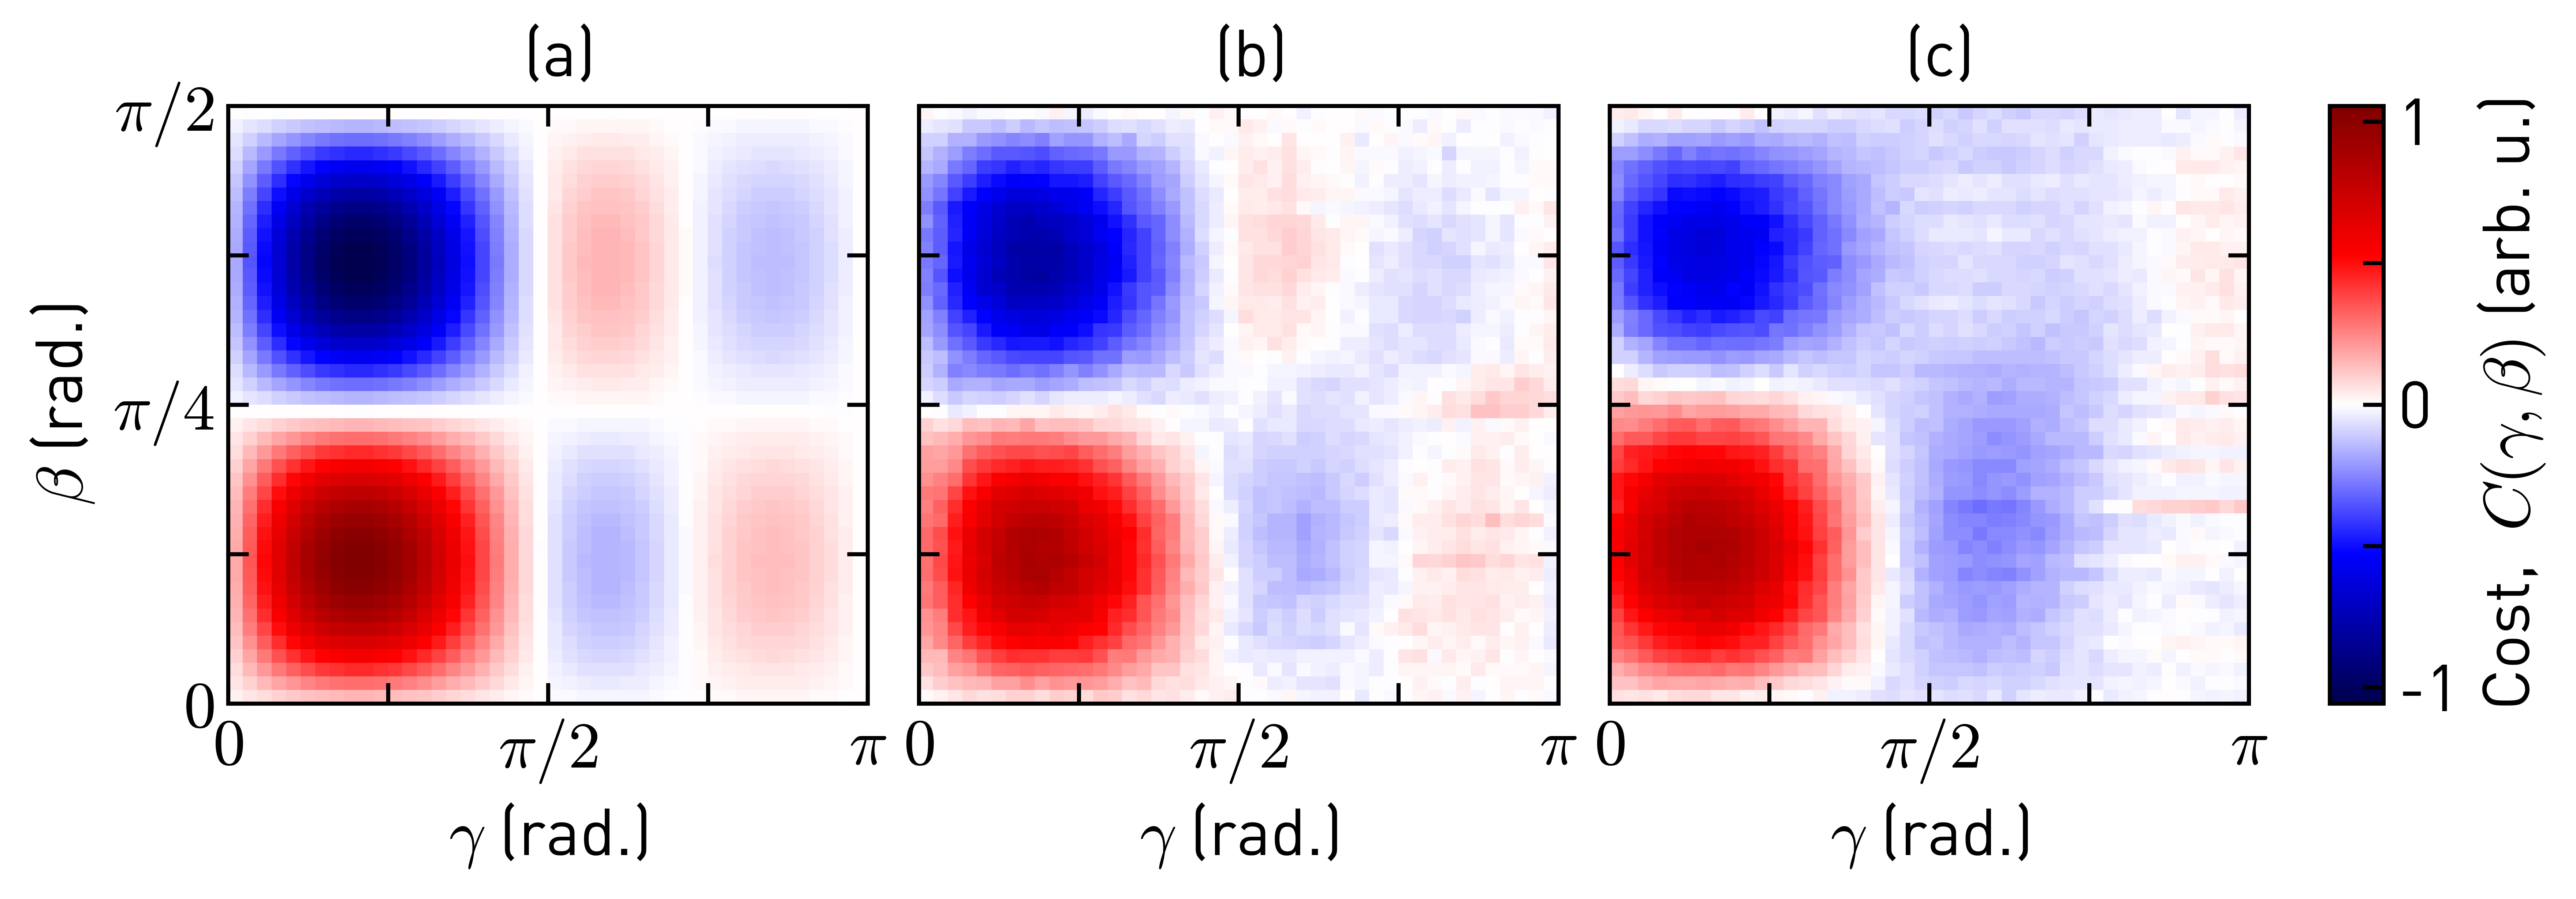

In [35]:
# plot landscapes
fig, ax = plt.subplots(ncols=3, sharey=True, 
                       figsize=(9.2,3), # vertical colorbar
#                        figsize=(9,3.5), # horizontal colorbar
                      )
cmap = "seismic"
for i, en in enumerate([energy_theory, energy_dir, energy_dec]):
    im = plot_colormesh(gg_dir*radians, bb_dir*radians, en, colorbar=False, 
                        labels=False, ax=ax[i],
#                         norm=mpl.colors.SymLogNorm(linthresh=0.05, linscale=1,
#                                               vmin=-1.5, vmax=1.5),
                   vmin=energy_theory.min(), 
                        vmax=energy_theory.max(),
                  xunits=radians, yunits=radians)
    ax[i].set_xlabel(r"$\gamma$ (rad.)")
    
### IMPORTANT NOTE: changed labels of beta to beta/2 because in fact my definition of 
# beta did not match farhi's definition of beta. This should not influence the results 
#but we should adapt the code in pycqed to have zgate(2beta) instead of zgate(beta)
plt.setp(ax, xticks=[i*np.pi/4 for i in range(5) ], 
         xticklabels=[r"$0$", r"", r"$\pi/2$", r"", r"$\pi$"], 
         yticks=[i*np.pi/8 for i in range(5) ], 
         yticklabels=[r"$0$", r"", r"$\pi/4$", r"", r"$\pi/2$"],
        )
plt.subplots_adjust(wspace=0.08)
# ax_cb = fig.add_axes([0.115,-0.03, 0.85, 0.05]) # for horizontal colorbar
ax_cb = fig.add_axes([0.88,0.2, 0.02, 0.68]) # for vertical colorbar
plt.subplots_adjust(bottom=0.2, right=0.85, left=0.1) # vertical
ax[0].set_ylabel(r"$\beta$ (rad.)")

cb = fig.colorbar(im, cax=ax_cb, ticks=[-1,-0.5,0,0.5,1],
                  label=r"Cost,  $C(\gamma, \beta)$ (arb. u.)", 
                  orientation="vertical")
cb.set_ticklabels(["-1", "", "0", "", "1"])

for a, l in zip(ax.flatten(), ["a", "b", "c"]):
    a.text(1.45, 1.65, f"({l})")

# fig.tight_layout()


In [357]:

fig.savefig(figsave_base + "qaoa_landscapes_{:%Y%m%d_%H%M%S}.pdf".format(datetime.datetime.now()), pad_inches =1, bbox='tight', bbox_extra_artists = [cb])

In [72]:
%matplotlib inline

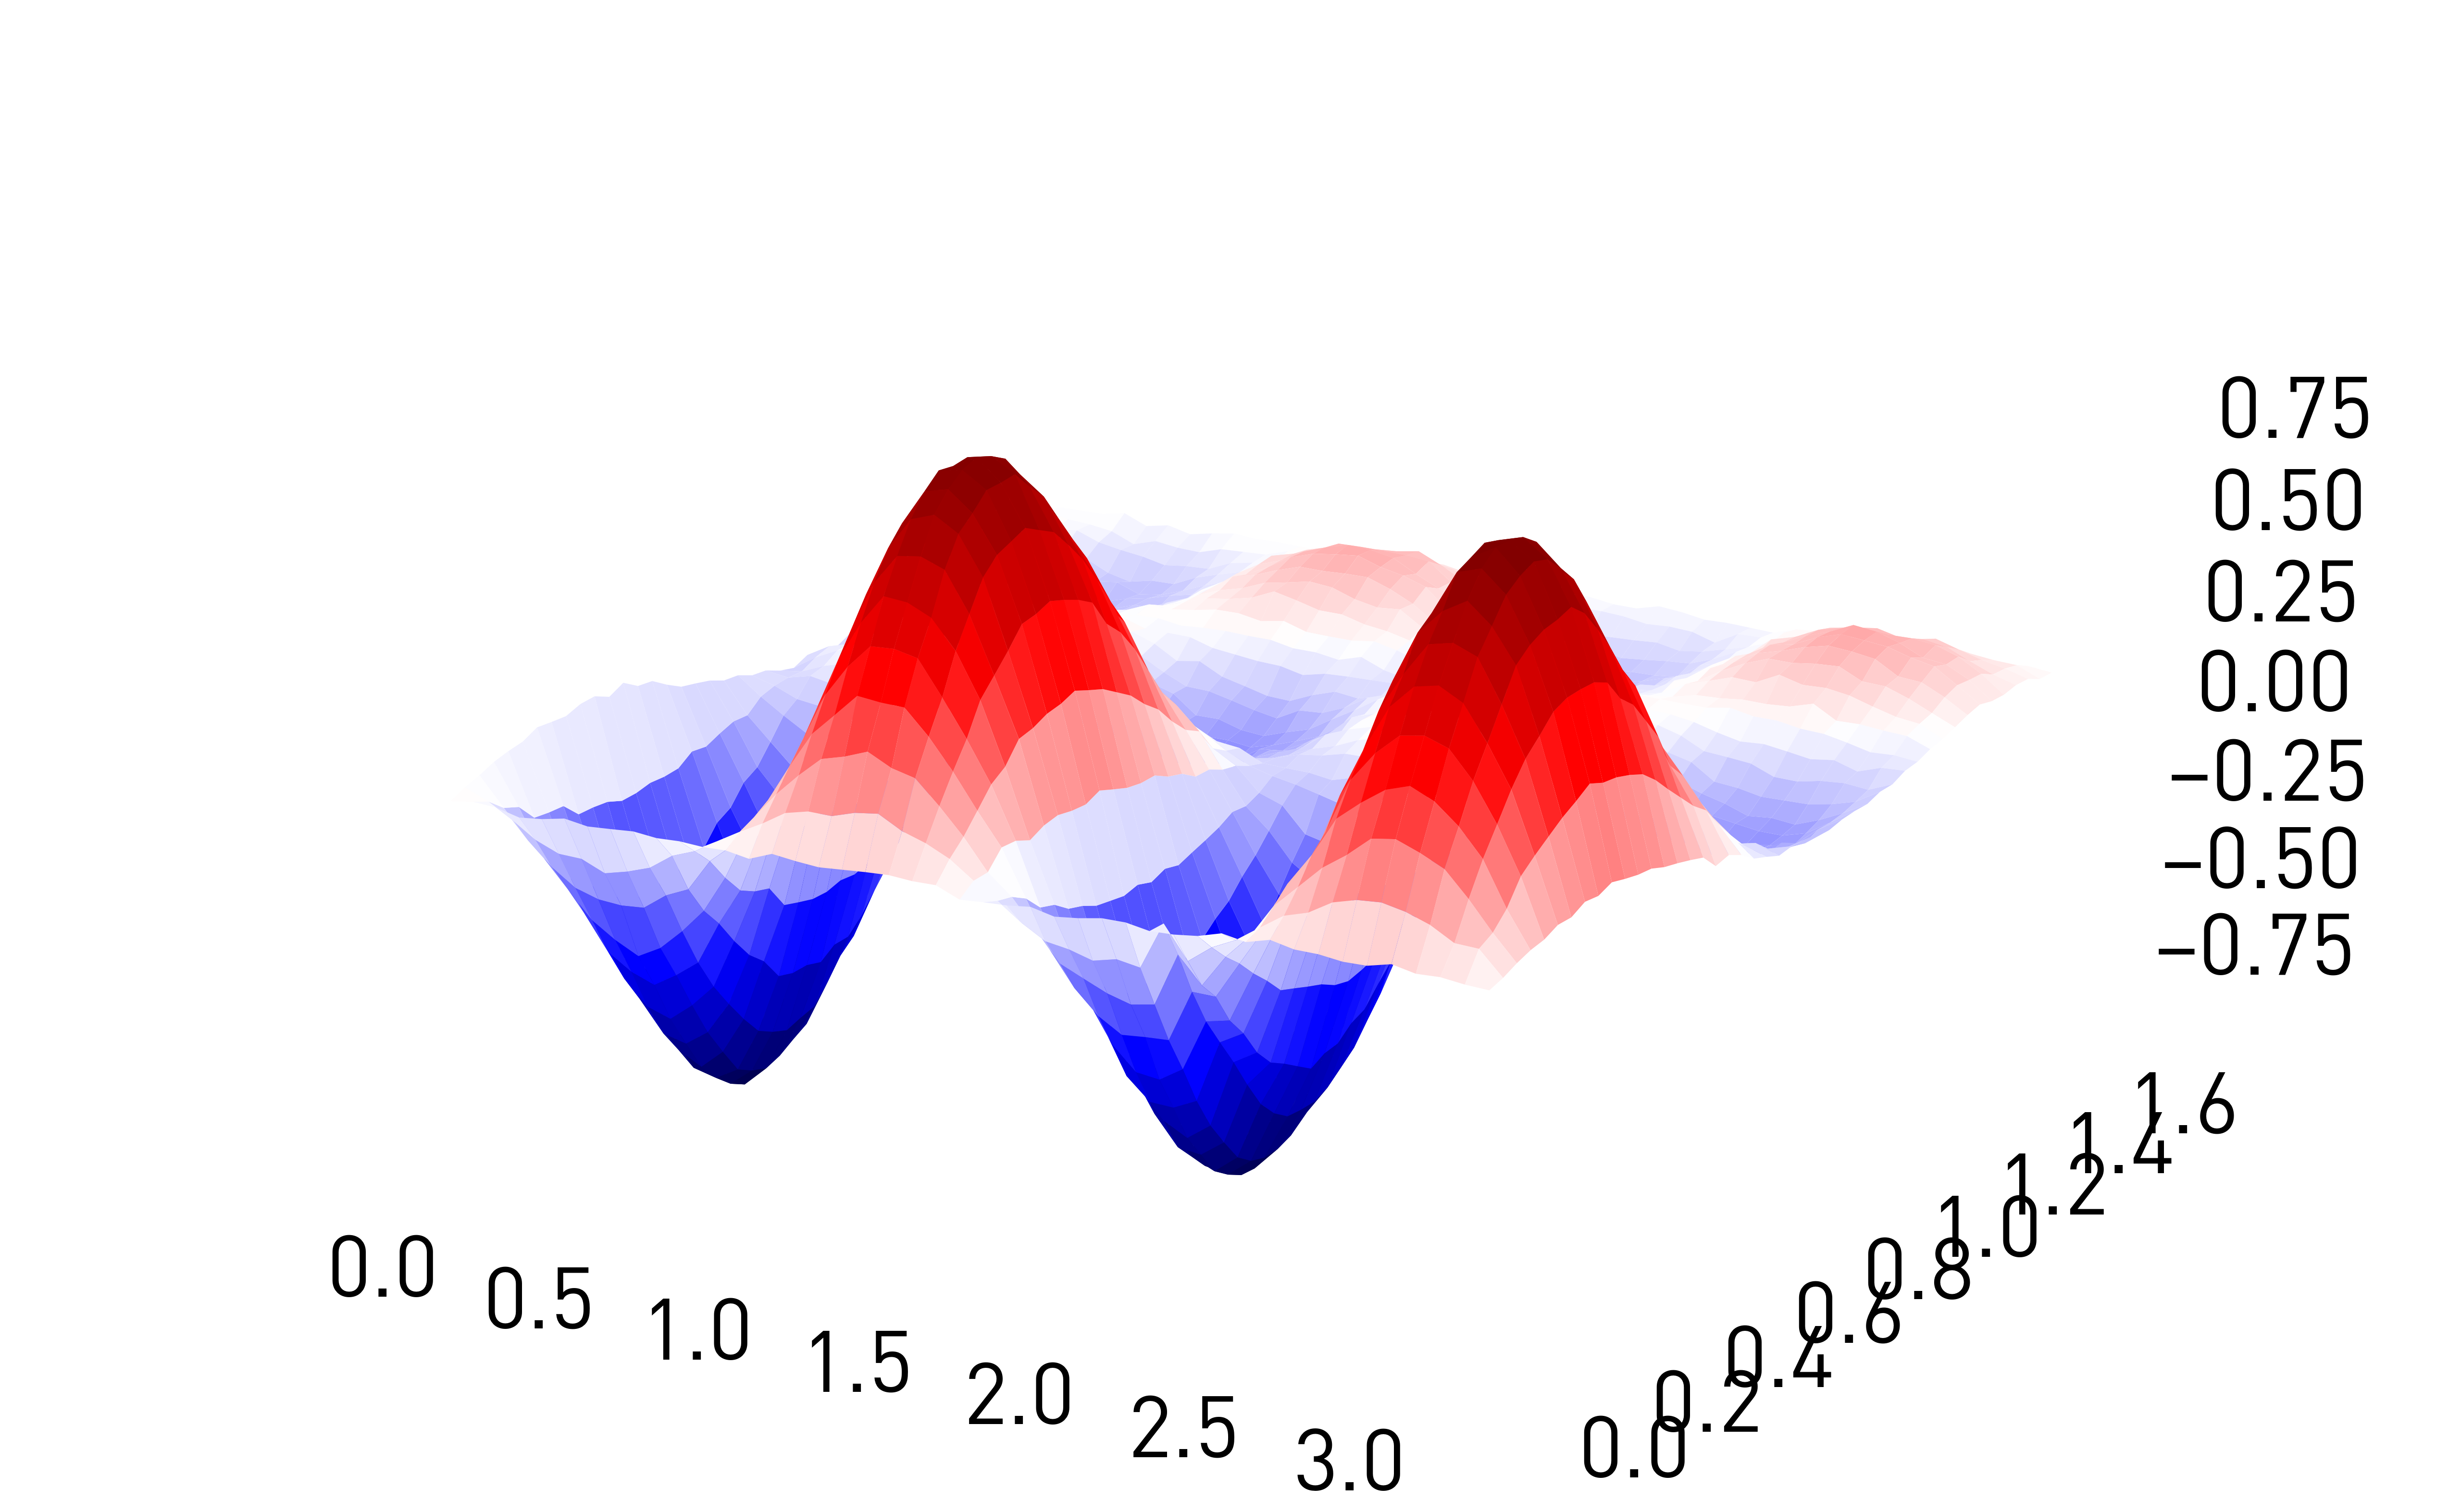

In [16]:
# plot landscape 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(g_closest, b_closest, energies +1, color= 'r', marker='o')
ax.plot_surface(gg, bb, energy_dir  , cmap="seismic", alpha=1)
# ax.plot_wireframe(gg, bb, energy_dir  , cmap="seismic", alpha=1)
plt.grid(False)
# ax.set_xlabel("\n $\\gamma$ (rad.)")
# ax.set_ylabel("\n $\\beta$ (rad.)")
# ax.set_zlim([-1,1])
# ax.set_zlabel("\nEnergy (arb. u.)")
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.xaxis._axinfo["tick"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["tick"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["tick"]['color'] =  (1,1,1,0)
ax.w_xaxis.line.set_color("w")
ax.w_yaxis.line.set_color("w")
ax.w_zaxis.line.set_color("w")
# fig.canvas.renderer.width = "500px"
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# plt.setp(ax, xticks=[i*np.pi/4 for i in range(5) ], 
#          xticklabels=[r"0", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"],
#          yticks=[i*np.pi/2 for i in range(5) ], 
#          yticklabels=[r"0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"],
#         )


In [47]:
base = energy_dir #np.arange(6).reshape((3, 2))
print(base)
np.flip(base)

[[-1.08695652e-02  7.51592357e-03  2.11023220e-02 ...  7.81012273e-03
  -3.37752044e-03 -1.13382144e-02]
 [-1.62684291e-03 -2.02995263e-02 -5.73544433e-02 ... -2.75087470e-02
  -1.74462898e-02 -1.09288225e-02]
 [-5.55696524e-03 -5.86273611e-02 -1.35700439e-01 ... -2.06159457e-02
  -2.17985721e-02 -9.57679216e-03]
 ...
 [ 2.54699200e-05  7.00653195e-02  1.66734934e-01 ...  3.87630440e-02
   1.96297803e-02 -1.34501732e-02]
 [-7.79623140e-03  6.68802767e-02  8.91516421e-02 ...  2.56676633e-02
   1.63024187e-02 -5.10592897e-03]
 [-1.12473402e-02  1.26890671e-03  1.98024842e-02 ...  7.83857591e-03
  -1.14550144e-02 -1.24327616e-02]]


array([[-1.24327616e-02, -1.14550144e-02,  7.83857591e-03, ...,
         1.98024842e-02,  1.26890671e-03, -1.12473402e-02],
       [-5.10592897e-03,  1.63024187e-02,  2.56676633e-02, ...,
         8.91516421e-02,  6.68802767e-02, -7.79623140e-03],
       [-1.34501732e-02,  1.96297803e-02,  3.87630440e-02, ...,
         1.66734934e-01,  7.00653195e-02,  2.54699200e-05],
       ...,
       [-9.57679216e-03, -2.17985721e-02, -2.06159457e-02, ...,
        -1.35700439e-01, -5.86273611e-02, -5.55696524e-03],
       [-1.09288225e-02, -1.74462898e-02, -2.75087470e-02, ...,
        -5.73544433e-02, -2.02995263e-02, -1.62684291e-03],
       [-1.13382144e-02, -3.37752044e-03,  7.81012273e-03, ...,
         2.11023220e-02,  7.51592357e-03, -1.08695652e-02]])

In [48]:
extended_1ax = np.concatenate([base, -base[::-1]])
extended_1ax

array([[-0.01086957,  0.00751592,  0.02110232, ...,  0.00781012,
        -0.00337752, -0.01133821],
       [-0.00162684, -0.02029953, -0.05735444, ..., -0.02750875,
        -0.01744629, -0.01092882],
       [-0.00555697, -0.05862736, -0.13570044, ..., -0.02061595,
        -0.02179857, -0.00957679],
       ...,
       [ 0.00555697,  0.05862736,  0.13570044, ...,  0.02061595,
         0.02179857,  0.00957679],
       [ 0.00162684,  0.02029953,  0.05735444, ...,  0.02750875,
         0.01744629,  0.01092882],
       [ 0.01086957, -0.00751592, -0.02110232, ..., -0.00781012,
         0.00337752,  0.01133821]])

In [49]:
extended_2ax = np.concatenate([extended_1ax, -extended_1ax[:, ::-1]], axis=1)
extended_2ax

array([[-0.01086957,  0.00751592,  0.02110232, ..., -0.02110232,
        -0.00751592,  0.01086957],
       [-0.00162684, -0.02029953, -0.05735444, ...,  0.05735444,
         0.02029953,  0.00162684],
       [-0.00555697, -0.05862736, -0.13570044, ...,  0.13570044,
         0.05862736,  0.00555697],
       ...,
       [ 0.00555697,  0.05862736,  0.13570044, ..., -0.13570044,
        -0.05862736, -0.00555697],
       [ 0.00162684,  0.02029953,  0.05735444, ..., -0.05735444,
        -0.02029953, -0.00162684],
       [ 0.01086957, -0.00751592, -0.02110232, ...,  0.02110232,
         0.00751592, -0.01086957]])

In [98]:
n = 1
total_row = np.tile(extended_2ax, n)
total = np.asarray(list(total_row)*n)

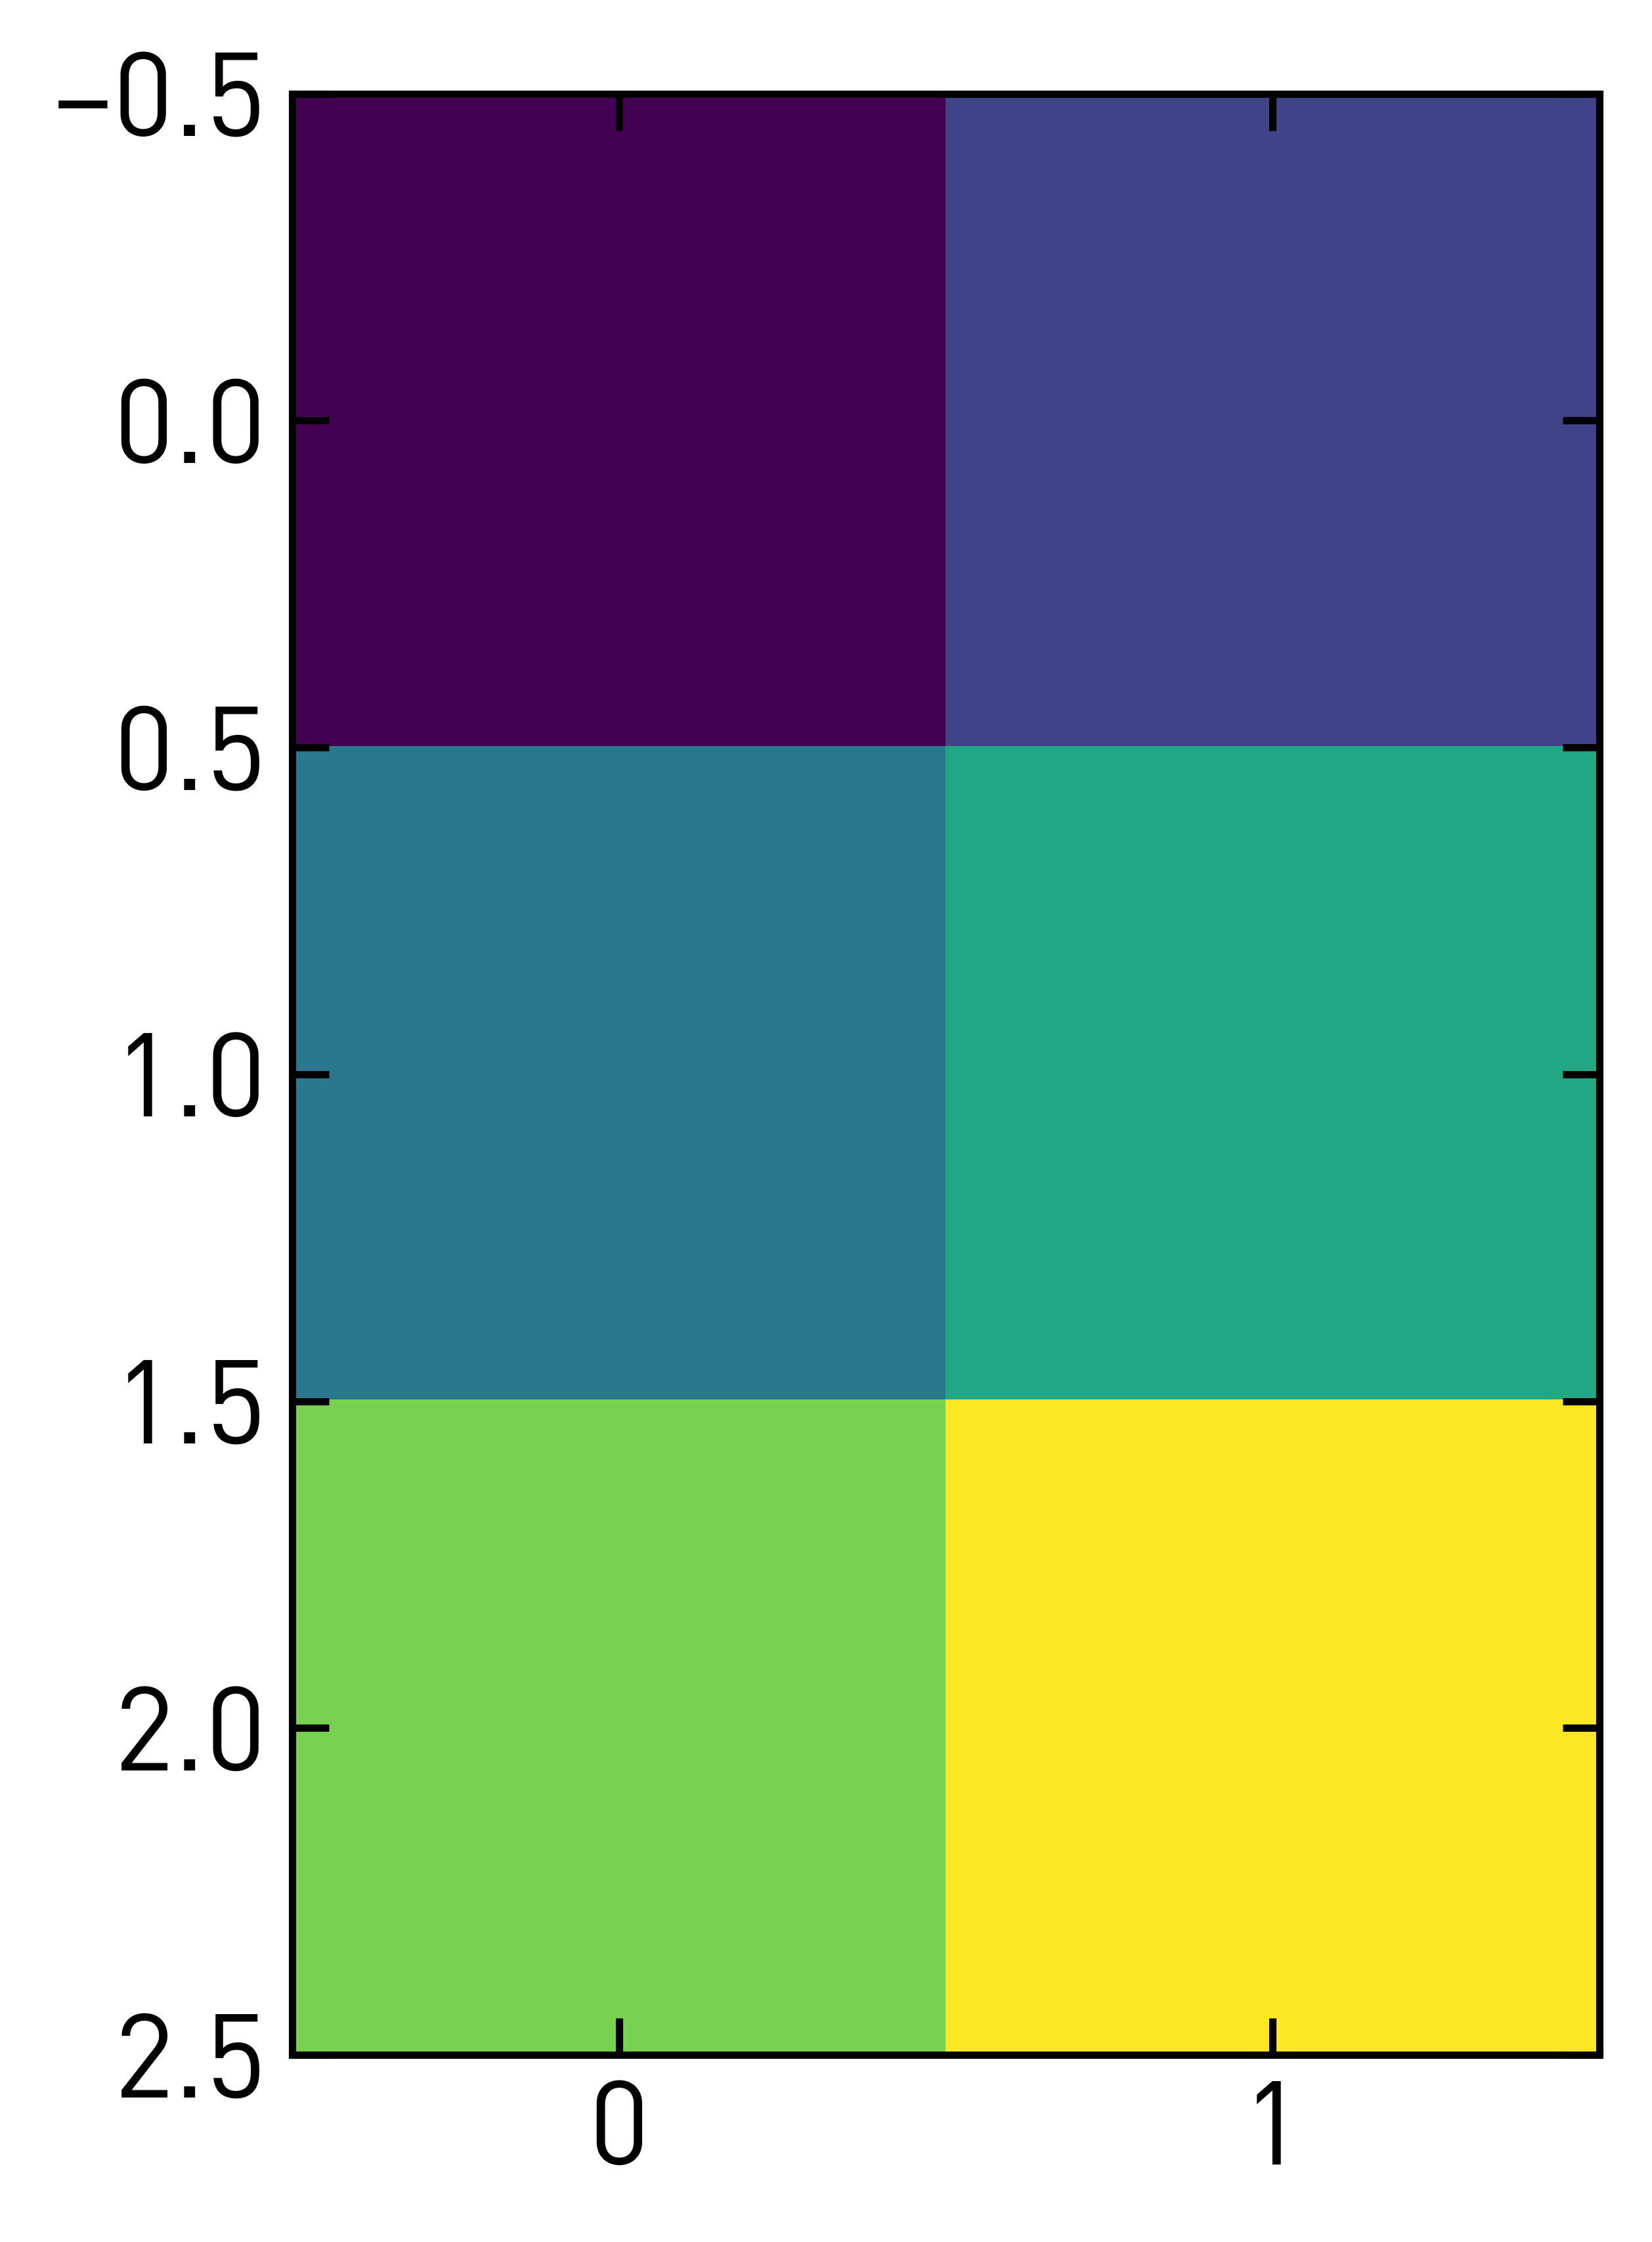

In [36]:
plt.imshow(base)

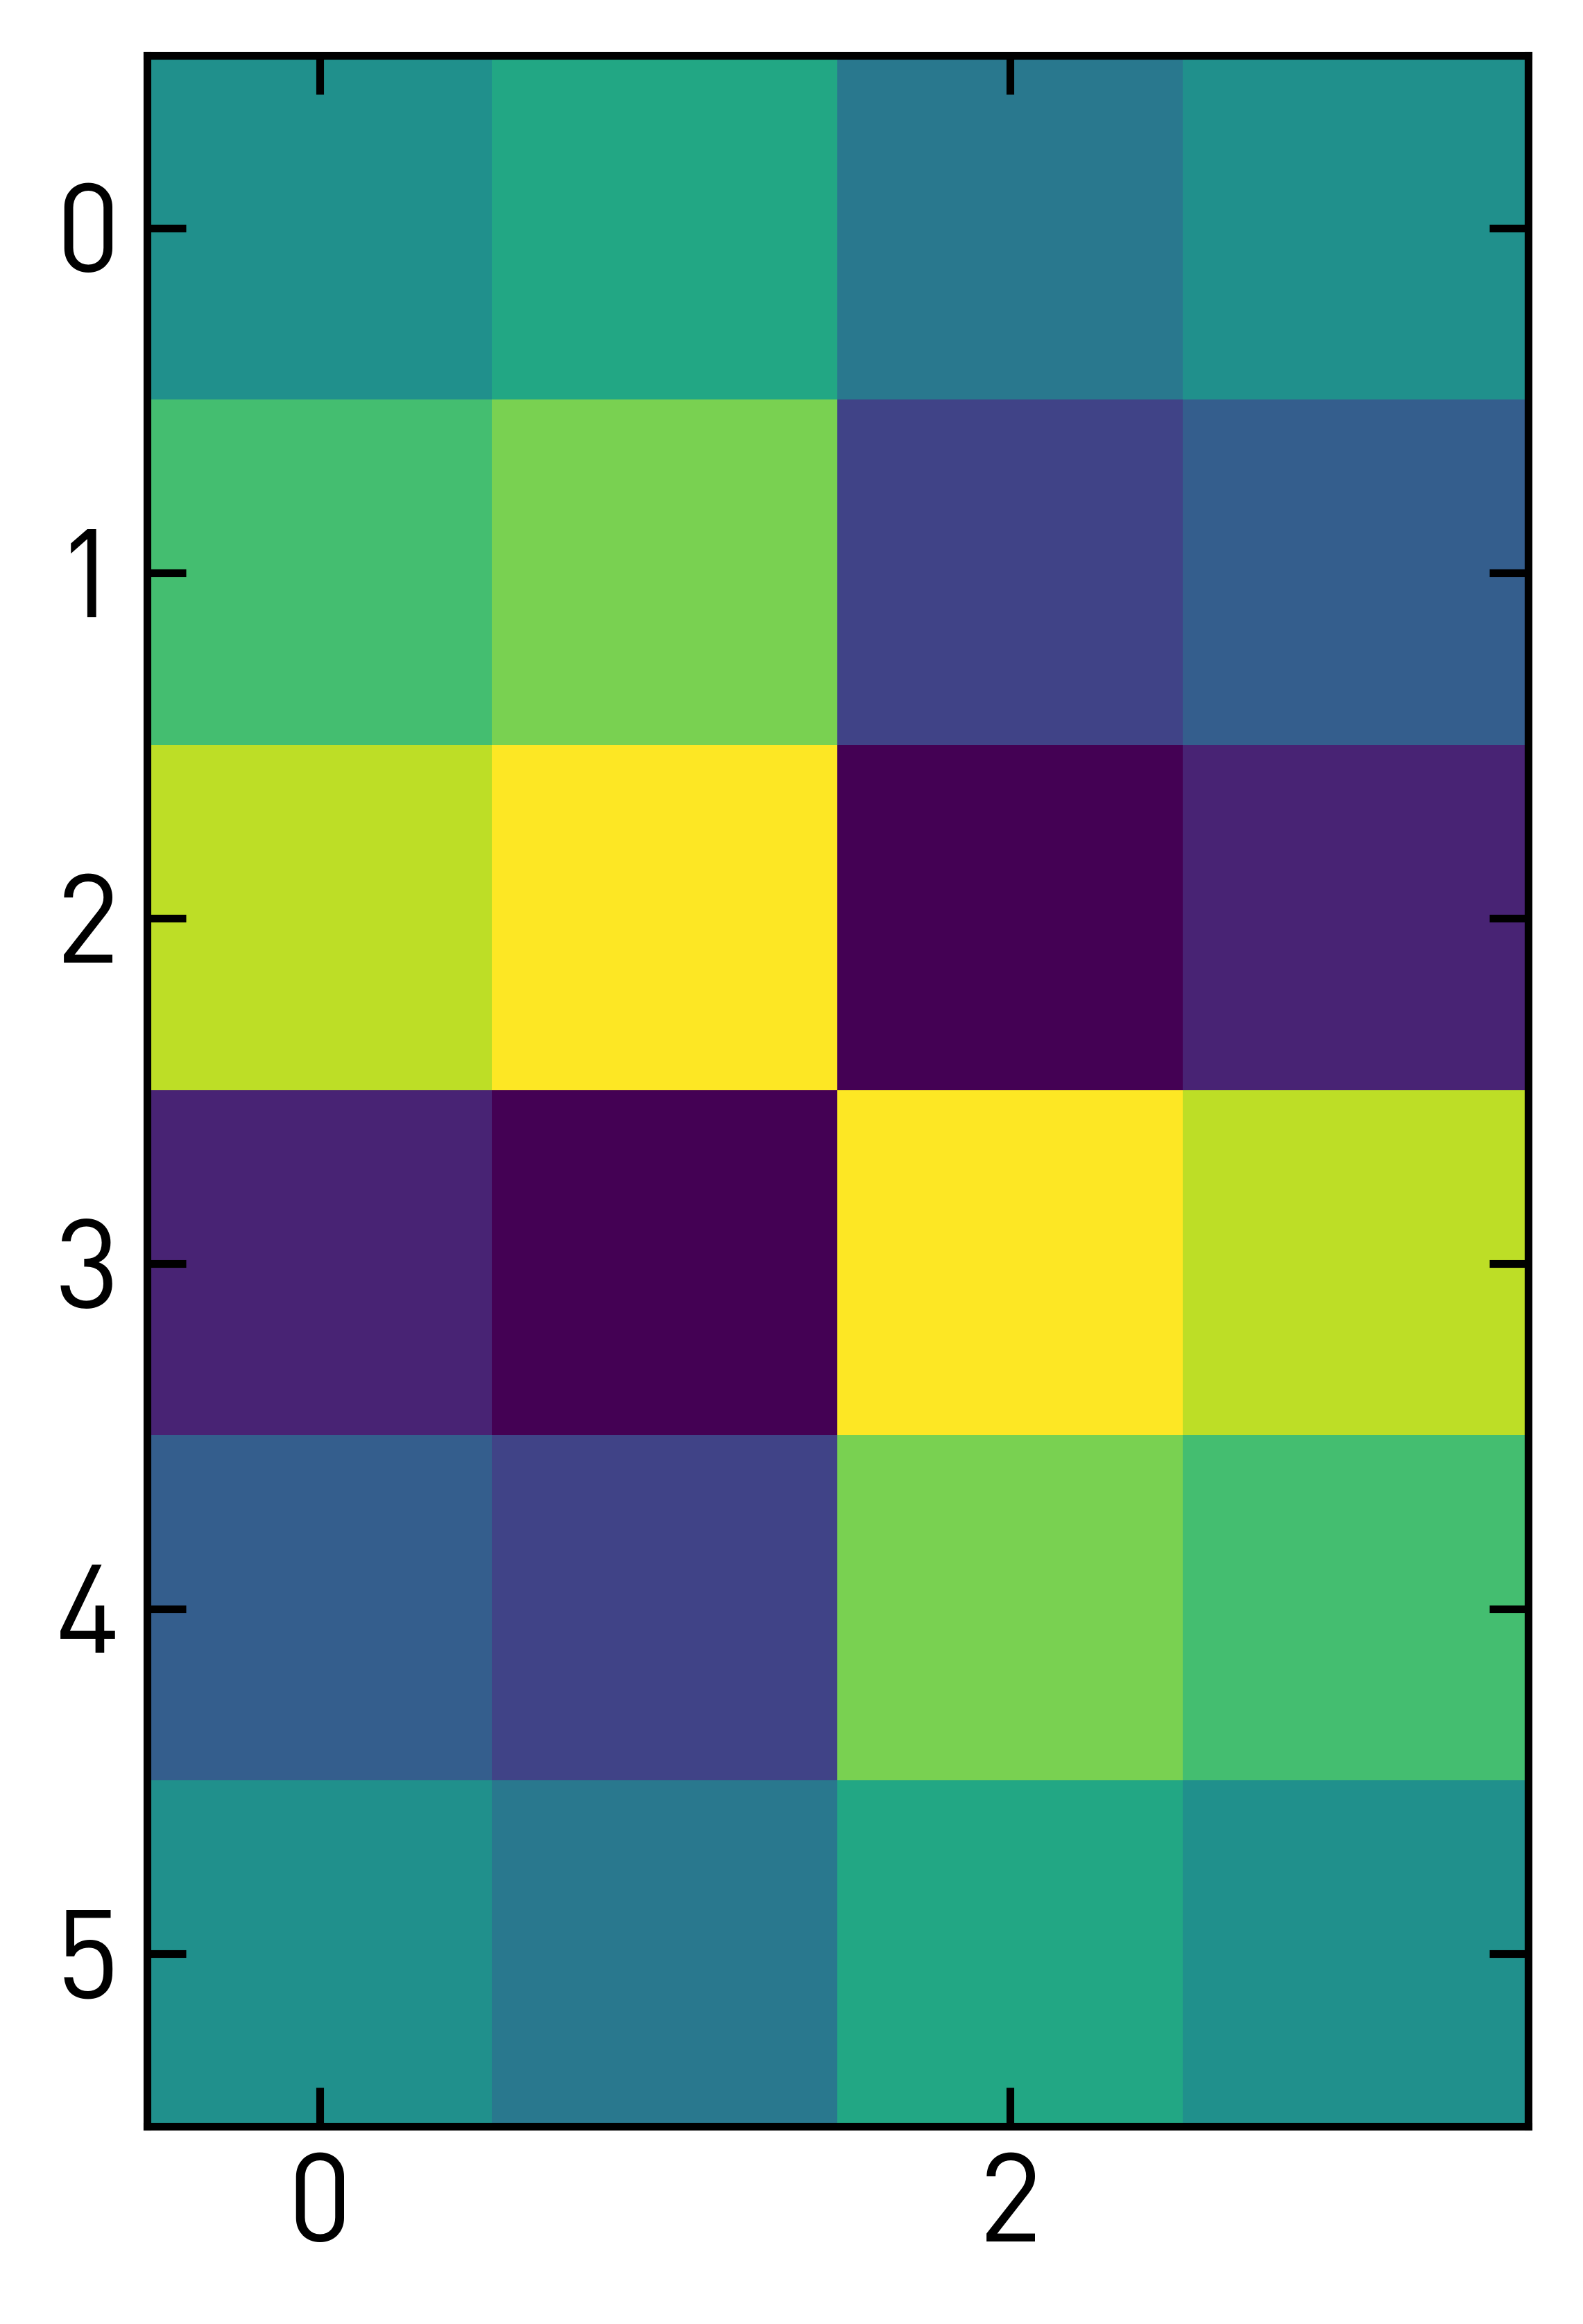

In [37]:
plt.imshow(extended_2ax)

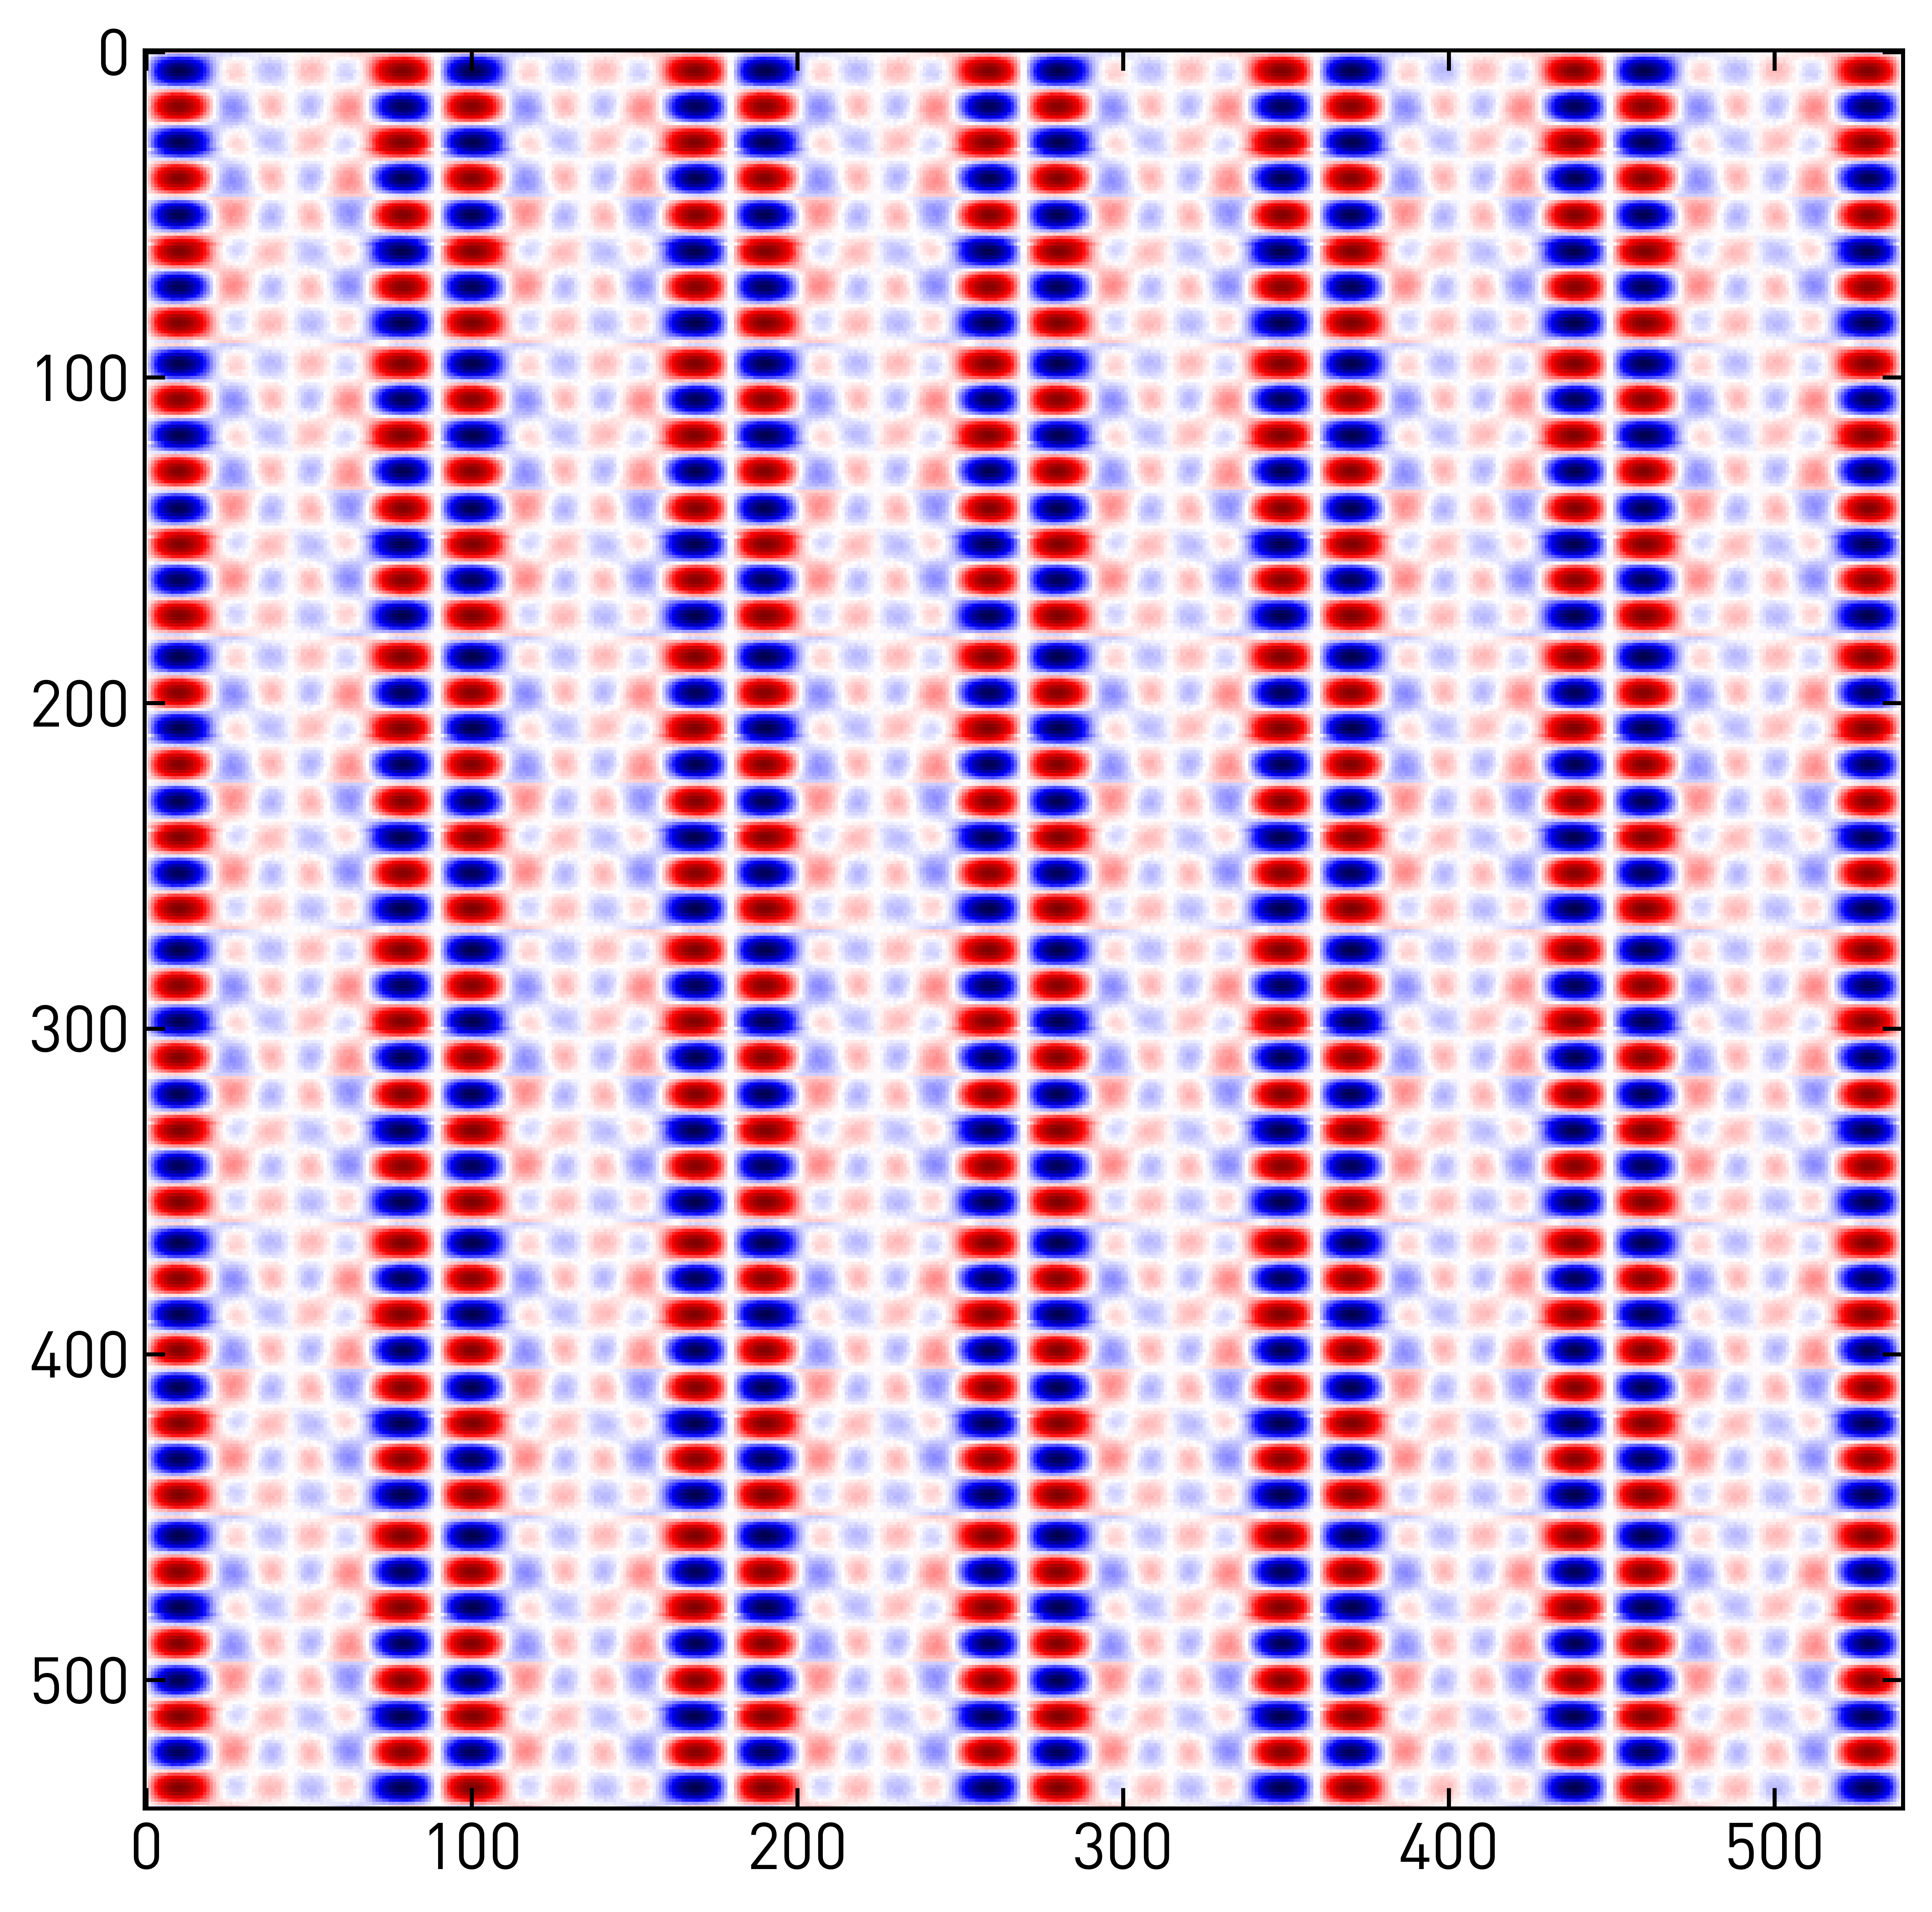

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(total, cmap="seismic")
ax.set_aspect(1)

In [64]:
6*45

270

In [100]:
g = np.linspace(0, 45, 2*n*45)
b = np.linspace(0, 45, 2*n*45)
gg, bb = np.meshgrid(g, b)

<IPython.core.display.Javascript object>


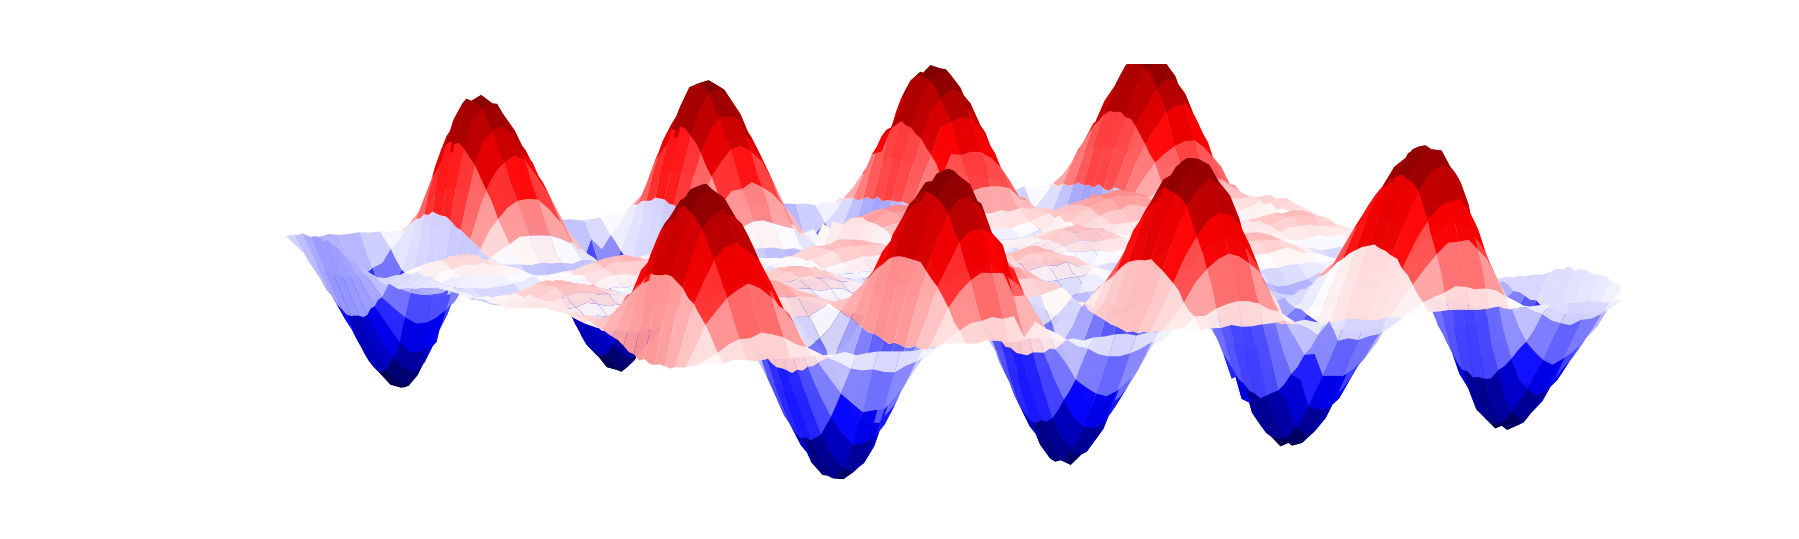

[]

In [101]:
# plot landscape 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111, projection='3d')
# ax.plot(g_closest, b_closest, energies +1, color= 'r', marker='o')
ax.plot_surface(gg, bb, total  , cmap="seismic", alpha=0.97)
# ax.plot_wireframe(gg, bb, energy_dir  , cmap="seismic", alpha=1)
plt.grid(False)
# ax.set_xlabel("\n $\\gamma$ (rad.)")
# ax.set_ylabel("\n $\\beta$ (rad.)")
# ax.set_zlim([-1,1])
# ax.set_zlabel("\nEnergy (arb. u.)")
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.xaxis._axinfo["tick"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["tick"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["tick"]['color'] =  (1,1,1,0)
ax.w_xaxis.line.set_color("w")
ax.w_yaxis.line.set_color("w")
ax.w_zaxis.line.set_color("w")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
# fig.canvas.renderer.width = "500px"
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# plt.setp(ax, xticks=[i*np.pi/4 for i in range(5) ], 
#          xticklabels=[r"0", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"],
#          yticks=[i*np.pi/2 for i in range(5) ], 
#          yticklabels=[r"0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"],
#         )

In [ ]:
v

In [76]:
%matplotlib notebook